# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [1]:
# Install the required libraries
# !pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
from datetime import timedelta
import numpy as np
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [3]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

# RS-Set Date Format of Latin America as:  Month Day Year HH:MM
mercado_trends_df = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=['Date'],
    date_format=lambda x: datetime.strptime(x, '%m/%d/%y %H:%M')
).dropna()        

# Review the first five rows of the DataFrame
display(mercado_trends_df.head(5))
# Review the last five rows of the DataFrame
# display(mercado_trends_df.tail(5))

,Search Trends
Date,
6/1/16 0:00,97
6/1/16 1:00,92
6/1/16 2:00,76
6/1/16 3:00,60
6/1/16 4:00,38


In [4]:
# Review the data types of the DataFrame using the info function
# mercado_trends_df.info()
mercado_trends_df.head(5)

,Search Trends
Date,
6/1/16 0:00,97
6/1/16 1:00,92
6/1/16 2:00,76
6/1/16 3:00,60
6/1/16 4:00,38


In [5]:

# Slice the DataFrame to just the month of May 2020
mercado_trends_df.index = pd.to_datetime(mercado_trends_df.index)
mercado_may2020_df = mercado_trends_df.loc['2020-05-01':'2020-05-31']
mercado_may2020_df = mercado_may2020_df.reset_index()
print(mercado_may2020_df.head)

# print(mercado_may2020_df.[0:0]) 
# print(mercado_may2020_df.index.max())
mercado_may2020_df.info()

C:\Users\resto\AppData\Local\Temp\ipykernel_4144\3829719820.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mercado_trends_df.index = pd.to_datetime(mercado_trends_df.index)


<bound method NDFrame.head of                    Date  Search Trends
0   2020-05-01 00:00:00             80
1   2020-05-01 01:00:00             80
2   2020-05-01 02:00:00             76
3   2020-05-01 03:00:00             66
4   2020-05-01 04:00:00             53
..                  ...            ...
739 2020-05-31 19:00:00             59
740 2020-05-31 20:00:00             64
741 2020-05-31 21:00:00             76
742 2020-05-31 22:00:00             90
743 2020-05-31 23:00:00             96

[744 rows x 2 columns]>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           744 non-null    datetime64[ns]
 1   Search Trends  744 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.8 KB


<Figure size 5000x1000 with 0 Axes>

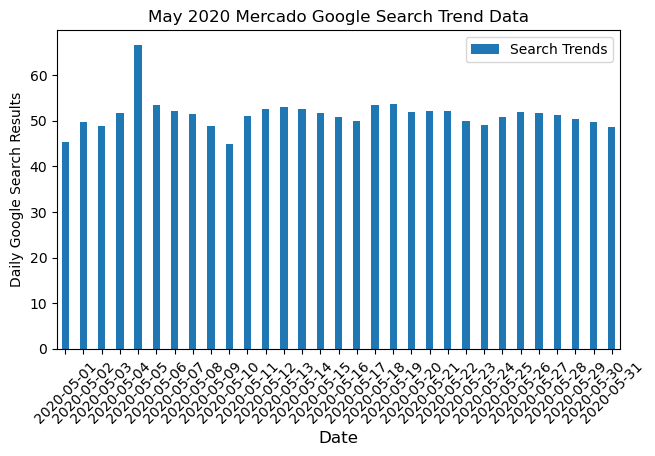

In [6]:
# Plot to visualize the data for May 2020
plt.figure(figsize=(50, 10)) 

# mercado_may2020_df[['Date','Search Trends']].plot(kind='bar')
mercado_daily_may2020_df = mercado_may2020_df.groupby(mercado_may2020_df['Date'].dt.date)['Search Trends'].mean().reset_index()

mercado_daily_may2020_df.plot(
    x='Date',
    y='Search Trends',
    kind='bar',
    width=0.4
)

plt.title('May 2020 Mercado Google Search Trend Data')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Google Search Results')
plt.tight_layout()
plt.xticks(rotation=45)  

plt.show()


#### Step 2: Calculate the total search traffic for the month, 
### and then compare the value to the monthly median across all months. 
### Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [7]:
# Calculate the sum of the total search traffic for May 2020
search_sum_may2020_meraco = mercado_may2020_df[mercado_may2020_df['Date'].dt.strftime('%Y-%m') == '2020-05']
print(type(search_sum_may2020_meraco))
print(search_sum_may2020_meraco)

# View the traffic_may_2020 value
traffic_may_2020 = search_sum_may2020_meraco['Search Trends'].sum()
traffic_may_2020

<class 'pandas.core.frame.DataFrame'>
                   Date  Search Trends
0   2020-05-01 00:00:00             80
1   2020-05-01 01:00:00             80
2   2020-05-01 02:00:00             76
3   2020-05-01 03:00:00             66
4   2020-05-01 04:00:00             53
..                  ...            ...
739 2020-05-31 19:00:00             59
740 2020-05-31 20:00:00             64
741 2020-05-31 21:00:00             76
742 2020-05-31 22:00:00             90
743 2020-05-31 23:00:00             96

[744 rows x 2 columns]


38181

In [8]:
# Calcluate the monthly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
mercado_2020_df = mercado_trends_df.loc['2020-01-01':'2020-12-31']
mercado_2020_df = mercado_2020_df.reset_index()

# View the median_monthly_traffic value
monthly_2020_traffic = mercado_2020_df.resample('ME', on='Date')['Search Trends'].sum()
monthly_2020_traffic = monthly_2020_traffic.median()
print(f"Median_Monthly_Traffic", monthly_2020_traffic)
# NOTE: Soure data ends at September of 2020, there is no 4Q data

Median_Monthly_Traffic 35229.0


In [9]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
# traffic_may_2020/median_monthly_traffic
may_vs_2020_difference_percentage = (traffic_may_2020 / monthly_2020_traffic)
print(traffic_may_2020 / monthly_2020_traffic)
print(f"Difference Between May vs. average Monthly Trends for 2020 (as a percentage): {may_vs_2020_difference_percentage:.2f}%")

1.0837946010389168
Difference Between May vs. average Monthly Trends for 2020 (as a percentage): 1.08%


##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:**  Yes, it did - May was Slightly up by 1.08%

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

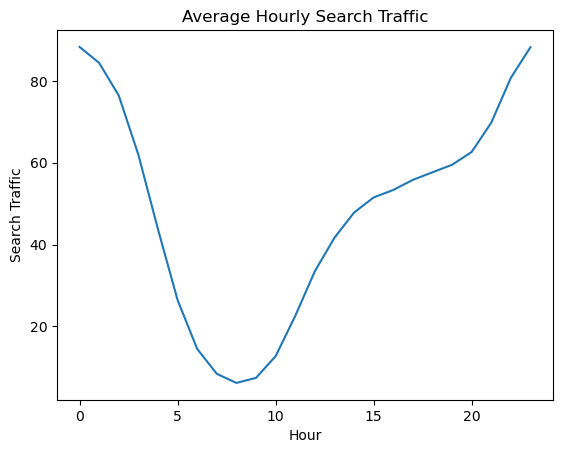

In [10]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`

# print(mercado_trends_df)
hourly_avg = mercado_trends_df['Search Trends'].groupby(mercado_trends_df.index.hour).mean()
# print(hourly_avg)

hourly_traffic_plot = hourly_avg.plot(
    title="Average Hourly Search Traffic",
    xlabel="Hour",
    ylabel="Search Traffic",
    rot=0  
)

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

Date
0    49.522813
1    50.571672
2    50.219604
3    49.699661
4    48.621041
5    45.125377
6    43.151207
Name: Search Trends, dtype: float64


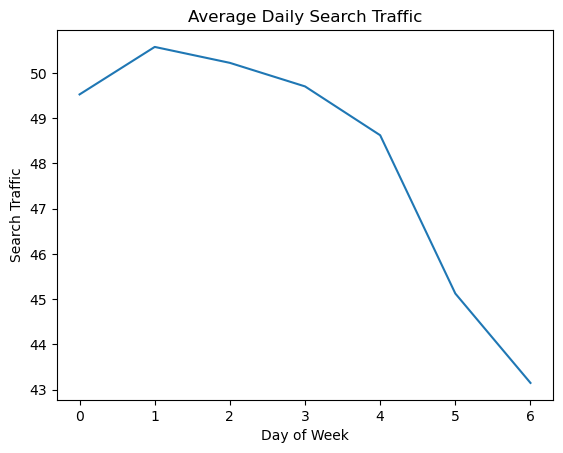

In [11]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
daily_avg = mercado_trends_df['Search Trends'].groupby(mercado_trends_df.index.dayofweek).mean()
print(daily_avg)

# Create plot
daily_traffic_plot = daily_avg.plot(
    title="Average Daily Search Traffic",
    xlabel="Day of Week",
    ylabel="Search Traffic",
    rot=0,
)

#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

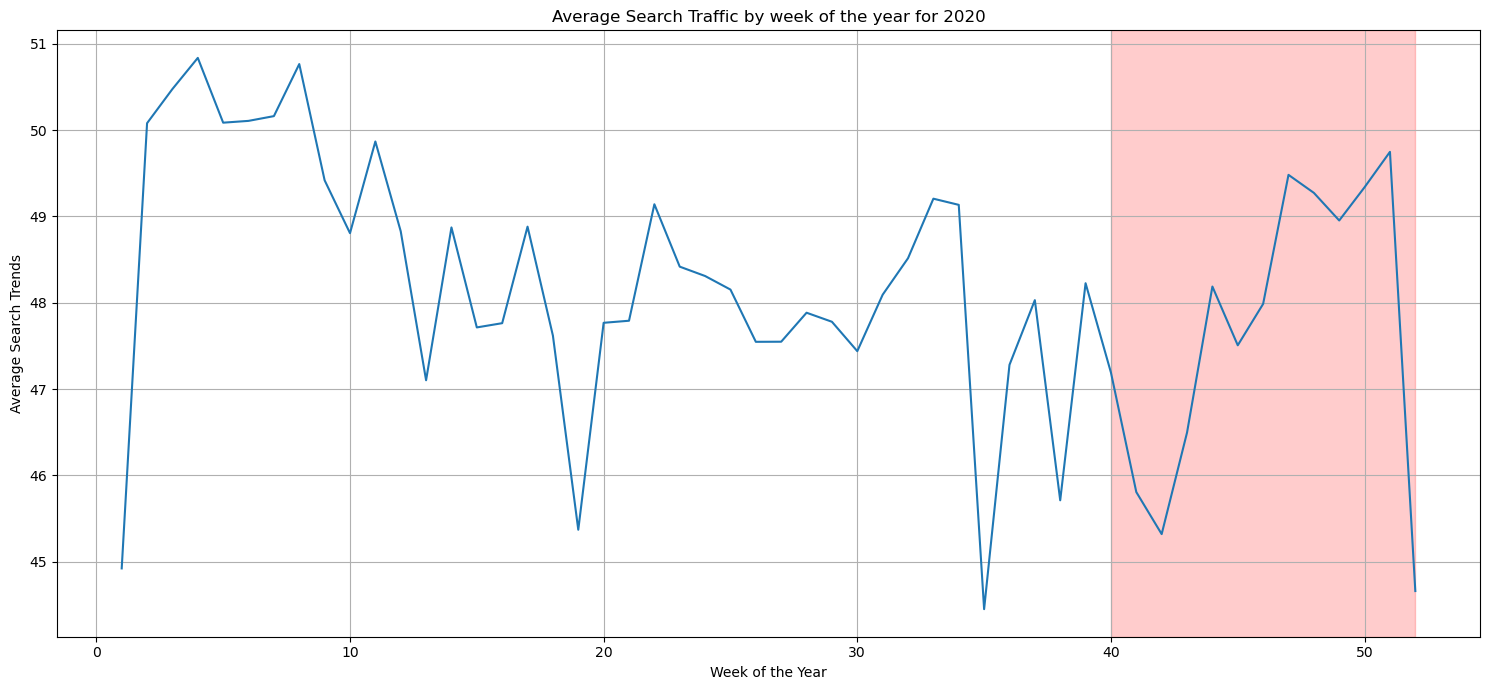

In [12]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
weekly_ave = mercado_trends_df['Search Trends'].groupby(mercado_trends_df.index.isocalendar().week).mean()
 
# Visualize / plot the 'weekly_ave'ArithmeticError
plt.figure(figsize=(15, 7))
weekly_ave.plot()
plt.title('Average Search Traffic by week of the year for 2020')
plt.xlabel('Week of the Year')
plt.ylabel('Average Search Trends')
plt.grid(True)
# Highlight in Red Holiday Shopping Weeks
plt.axvspan(40, 52, color='red', alpha=0.2)
plt.tight_layout()
plt.show()

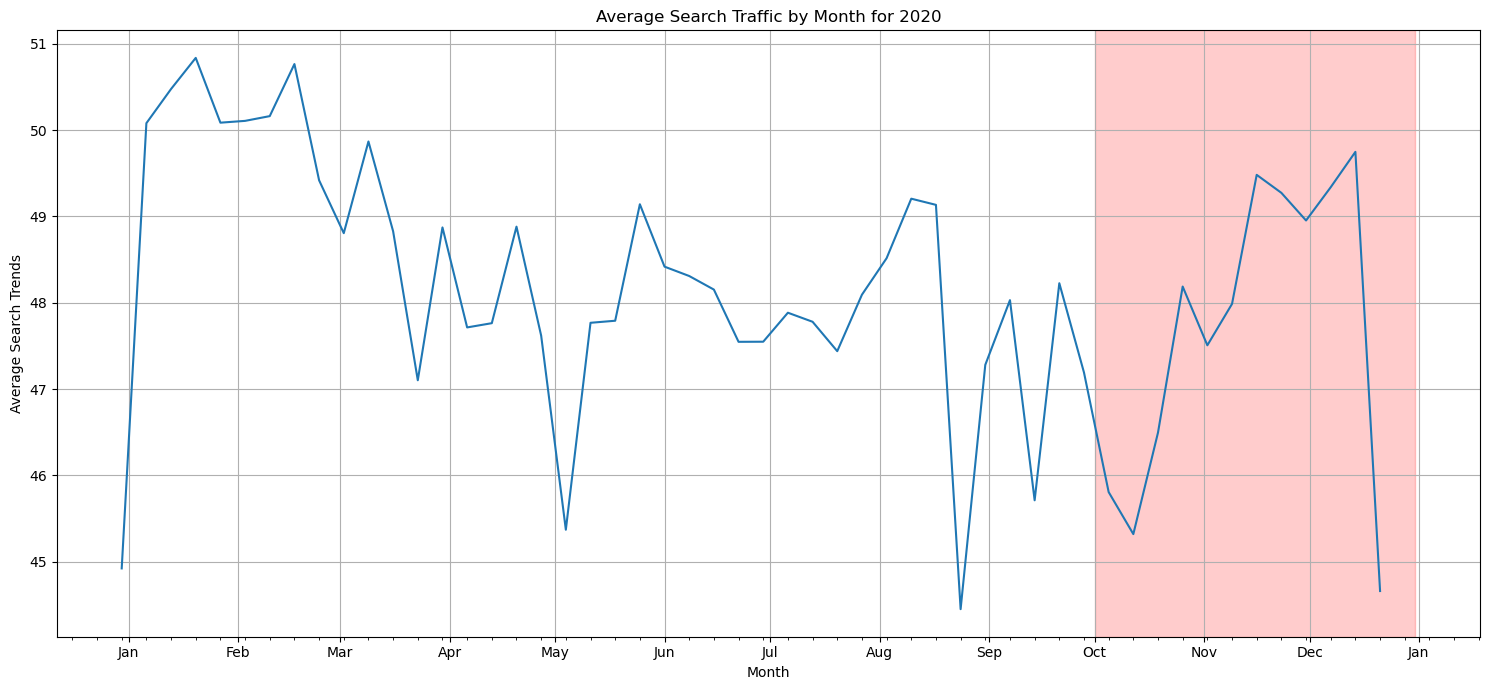

In [13]:
year = 2020 
# Mapping from week number to a representative first day of each week
week_to_date = {}
for week in range(1, 53):  # Weeks 1-52
    # Calculate the date of the Monday of this week
    date = datetime(year, 1, 1) + timedelta(days=(week-1)*7)
    # Adjust to the Monday of that week
    monday = date - timedelta(days=date.weekday())
    week_to_date[week] = monday

# Create a new DataFrame with dates as the index
date_indexed_data = pd.DataFrame(index=[week_to_date[week] for week in weekly_ave.index], 
                                 data=weekly_ave.values,
                                 columns=['Search Trends'])

# Sort by date to ensure proper ordering
date_indexed_data = date_indexed_data.sort_index()

# Create the plot with date-formatted x-axis
plt.figure(figsize=(15, 7))
plt.plot(date_indexed_data.index, date_indexed_data['Search Trends'])

# Format the x-axis to show months with weekly tick marks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks on months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Format as abbreviated month name
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=0))  # Minor ticks on Mondays (weekly)

# Set title and labels
plt.title('Average Search Traffic by Month for 2020')
plt.xlabel('Month')
plt.ylabel('Average Search Trends')
plt.grid(True)

# Highlighting the holiday shopping period (Oct-Dec)
holiday_start = datetime(year, 10, 1)  # October 1st
holiday_end = datetime(year, 12, 31)   # December 31st
plt.axvspan(holiday_start, holiday_end, color='red', alpha=0.2)

plt.tight_layout()
plt.show()

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:** Yes, Searchs trend down at Latin American Holidays, Cinco de Mayo, and major Christian holidays such as Christmas, and New Years. Increased activity leading up to All Souls Day / Halloween.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [14]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
mercado_stock_df = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first five rows of the DataFrame
display(mercado_stock_df.head(5))
# View the last five rows of the DataFrame
# display(mercado_stock_df.tail(5))

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


<Figure size 1500x700 with 0 Axes>

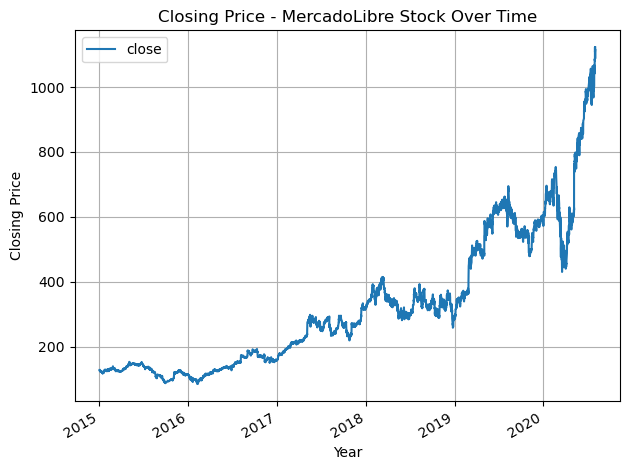

In [15]:
# Visualize the closing price of the mercado_stock_df DataFrame
plt.figure(figsize=(15, 7))
mercado_stock_df.plot()
plt.title('Closing Price - MercadoLibre Stock Over Time')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Concatenate the mercado_stock_df DataFrame with the mercado_trends_df DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
mercado_stock_trends_df = pd.concat([mercado_stock_df, mercado_trends_df], axis=1).dropna()

# --------------------
# mercado_stock_trends_df = pd.concat([mercado_trends_df, mercado_stock_df], axis=1)
# mercado_stock_trends_df =mercado_stock_trends_df.dropna()

# # View the first and last five rows of the DataFrame
# # mercado_stock_trends_df.head()
display(mercado_stock_trends_df.tail())
display(mercado_stock_trends_df.columns)

,close,Search Trends
2020-07-31 11:00:00,1105.780,20.0
2020-07-31 12:00:00,1087.925,32.0
2020-07-31 13:00:00,1095.800,41.0
2020-07-31 14:00:00,1110.650,47.0
2020-07-31 15:00:00,1122.510,53.0


Index(['close', 'Search Trends'], dtype='object')

#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [17]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
mercado_stock_trends_q1q2_df = mercado_stock_trends_df.loc['2020-01-01':'2020-06-30']
mercado_stock_trends_q1q2_df = mercado_stock_trends_q1q2_df.reset_index()


# View the first and last five rows of first_half_2020 DataFrame
# mercado_stock_trends_q1q2_df.head(5)
# mercado_stock_trends_q1q2_df.tail(5)
print(mercado_stock_trends_q1q2_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   index          807 non-null    datetime64[ns]
 1   close          807 non-null    float64       
 2   Search Trends  807 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 19.0 KB
None


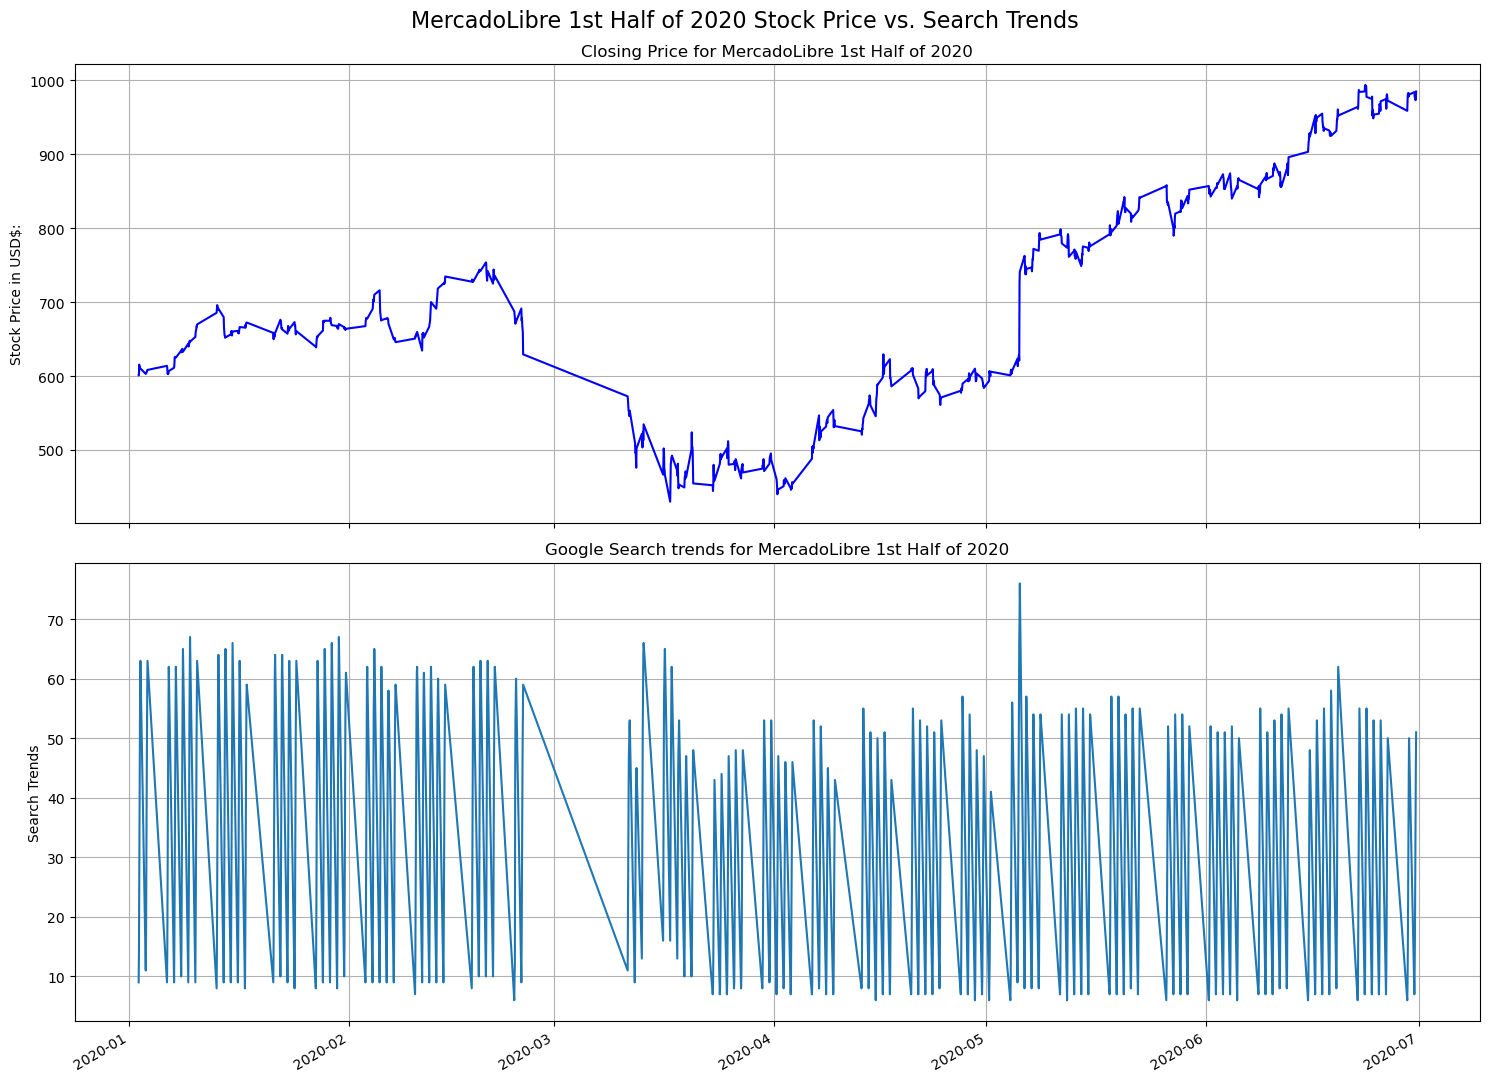

In [18]:
# Visualize the close and Search Trends data
fig, axes = plt.subplots(2,1, figsize=(15, 11),sharex=True)

# FIRST half / plot
axes[0].plot(mercado_stock_trends_q1q2_df['index'], mercado_stock_trends_q1q2_df['close'], 'b-')
axes[0].set_title('Closing Price for MercadoLibre 1st Half of 2020')
axes[0].set_ylabel('Stock Price in USD$:')
axes[0].grid(True)
# plt.subplots_adjust(top=0.95)
# plt.tight_layout()
# plt.show()

# SECOND Overlay Plot:
axes[1].plot(mercado_stock_trends_q1q2_df['index'], mercado_stock_trends_q1q2_df['Search Trends'])
axes[1].set_title('Google Search trends for MercadoLibre 1st Half of 2020')
axes[1].set_ylabel('Search Trends')
axes[1].grid(True)

# Overall Params:
fig.autofmt_xdate()
plt.suptitle('MercadoLibre 1st Half of 2020 Stock Price vs. Search Trends', fontsize=16, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:**  No, these two plots appear dis-similar to one another.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [19]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
mercado_stock_trends_df['Lagged Search Trends'] = mercado_stock_trends_df['Search Trends'].shift(1)
mercado_stock_trends_df.head()

,close,Search Trends,Lagged Search Trends
2016-06-01 09:00:00,135.16,6.0,NaN
2016-06-01 10:00:00,136.63,12.0,6.0
2016-06-01 11:00:00,136.56,22.0,12.0
2016-06-01 12:00:00,136.42,33.0,22.0
2016-06-01 13:00:00,136.10,40.0,33.0


In [20]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
mercado_stock_trends_df['Stock Volatility'] = mercado_stock_trends_df['close'].pct_change().rolling(window=4).std()
mercado_stock_trends_df.head()


,close,Search Trends,Lagged Search Trends,Stock Volatility
2016-06-01 09:00:00,135.16,6.0,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,NaN
2016-06-01 11:00:00,136.56,22.0,12.0,NaN
2016-06-01 12:00:00,136.42,33.0,22.0,NaN
2016-06-01 13:00:00,136.10,40.0,33.0,0.006134


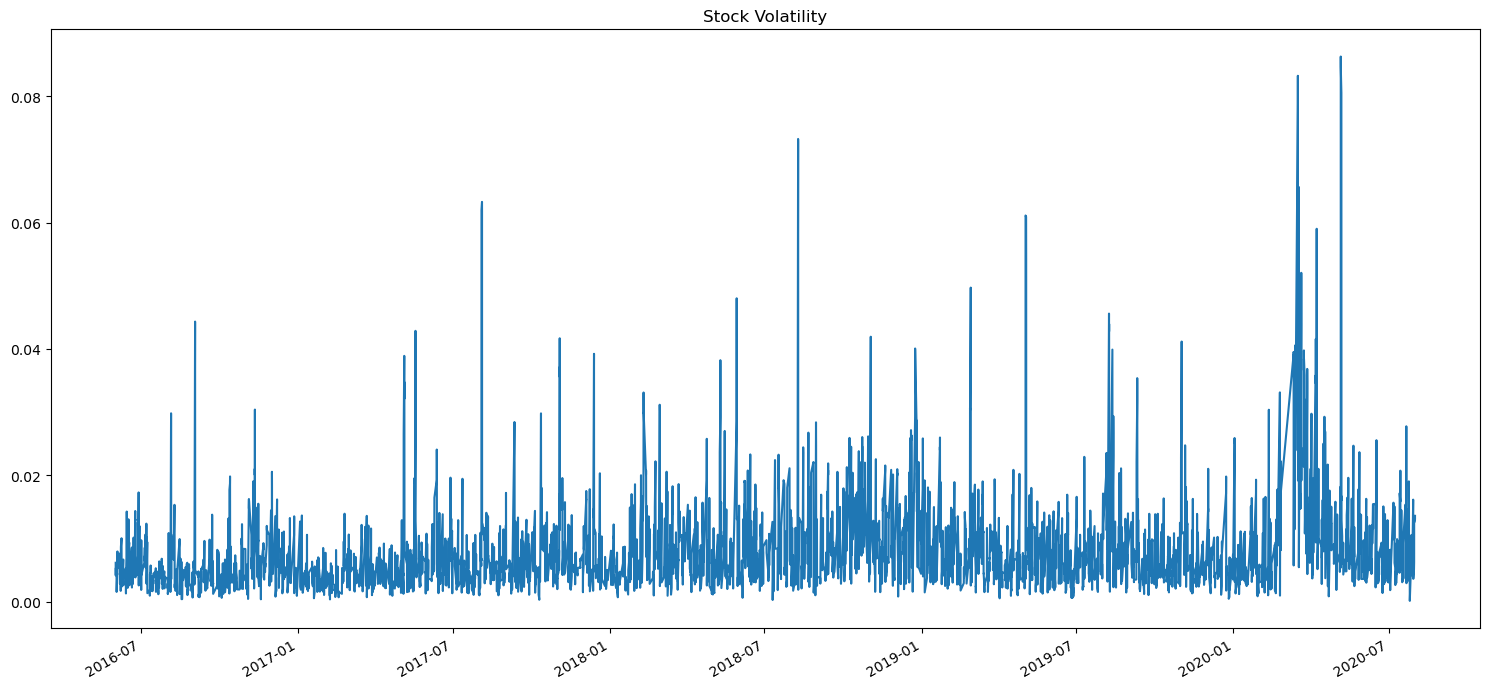

In [21]:
# Visualize the stock volatility
plt.figure(figsize=(15, 7))
mercado_stock_trends_df['Stock Volatility'].plot()
plt.title('Stock Volitity - MercadoLibre Stock Over Time')
plt.title('Stock Volatility')
plt.tight_layout()
plt.show()


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [22]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
mercado_stock_trends_df['Hourly Stock Return'] = mercado_stock_trends_df['close'].pct_change()
mercado_stock_trends_df.head(5)

,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.16,6.0,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,NaN,0.010876
2016-06-01 11:00:00,136.56,22.0,12.0,NaN,-0.000512
2016-06-01 12:00:00,136.42,33.0,22.0,NaN,-0.001025
2016-06-01 13:00:00,136.10,40.0,33.0,0.006134,-0.002346


In [23]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(mercado_stock_trends_df.head(5))
display(mercado_stock_trends_df.tail(5))

,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.16,6.0,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,NaN,0.010876
2016-06-01 11:00:00,136.56,22.0,12.0,NaN,-0.000512
2016-06-01 12:00:00,136.42,33.0,22.0,NaN,-0.001025
2016-06-01 13:00:00,136.10,40.0,33.0,0.006134,-0.002346


,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,1105.780,20.0,11.0,0.012837,0.006380
2020-07-31 12:00:00,1087.925,32.0,20.0,0.013549,-0.016147
2020-07-31 13:00:00,1095.800,41.0,32.0,0.013295,0.007239
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013001,0.013552
2020-07-31 15:00:00,1122.510,53.0,47.0,0.013566,0.010678


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [24]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
mercado_stock_trends_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** Between the lagged search traffic and the stock volatility, there is a weak relationship displayed here (-0.148), which suggests higher seaarch activities may preceed lower Volity periods. Between the lagged search traffic and the stock price returns, the correlation table shows '0.018' which indicatesvery little predictivde relationship between thesetwo features. These weak indicators suggest, Search traffic alone is not a strong predictor for stock performance, or volatitivy.  

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [25]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
mercado_prophet_df = mercado_trends_df.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet
mercado_prophet_df.columns = ['ds', 'y']

# Drop an NaN values from the prophet_df DataFrame
mercado_prophet_df = mercado_prophet_df.dropna()

# View the first and last five rows of the mercado_prophet_df DataFrame
mercado_prophet_df

,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38
...,...,...
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97


In [26]:
# Call the Prophet function, store as an object
model_mercado_trends = Prophet()

In [27]:
# Fit the time-series model.
model_mercado_trends.fit(mercado_prophet_df)


23:43:12 - cmdstanpy - INFO - Chain [1] start processing
23:43:36 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_trends = model_mercado_trends.make_future_dataframe(periods=2000, freq='h') 

# View the last five rows of the future_mercado_trends DataFrame
future_mercado_trends.tail(5)

,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [29]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_mercado_trends = model_mercado_trends.predict(future_mercado_trends)

# Display the first five rows of the forecast_mercado_trends DataFrame
display(forecast_mercado_trends.head(5))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.352625,81.391938,97.901098,44.352625,44.352625,45.307367,45.307367,45.307367,41.452720,...,1.860390,1.860390,1.860390,1.994257,1.994257,1.994257,0.0,0.0,0.0,89.659992
1,2016-06-01 01:00:00,44.353557,77.873208,95.039450,44.353557,44.353557,41.753097,41.753097,41.753097,37.943514,...,1.810288,1.810288,1.810288,1.999294,1.999294,1.999294,0.0,0.0,0.0,86.106654
2,2016-06-01 02:00:00,44.354489,67.365693,84.880998,44.354489,44.354489,31.429548,31.429548,31.429548,27.656552,...,1.768695,1.768695,1.768695,2.004301,2.004301,2.004301,0.0,0.0,0.0,75.784037
3,2016-06-01 03:00:00,44.355421,51.840577,69.416239,44.355421,44.355421,16.162280,16.162280,16.162280,12.417302,...,1.735704,1.735704,1.735704,2.009275,2.009275,2.009275,0.0,0.0,0.0,60.517701
4,2016-06-01 04:00:00,44.356353,35.286604,51.717163,44.356353,44.356353,-0.952639,-0.952639,-0.952639,-4.678127,...,1.711270,1.711270,1.711270,2.014218,2.014218,2.014218,0.0,0.0,0.0,43.403713


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

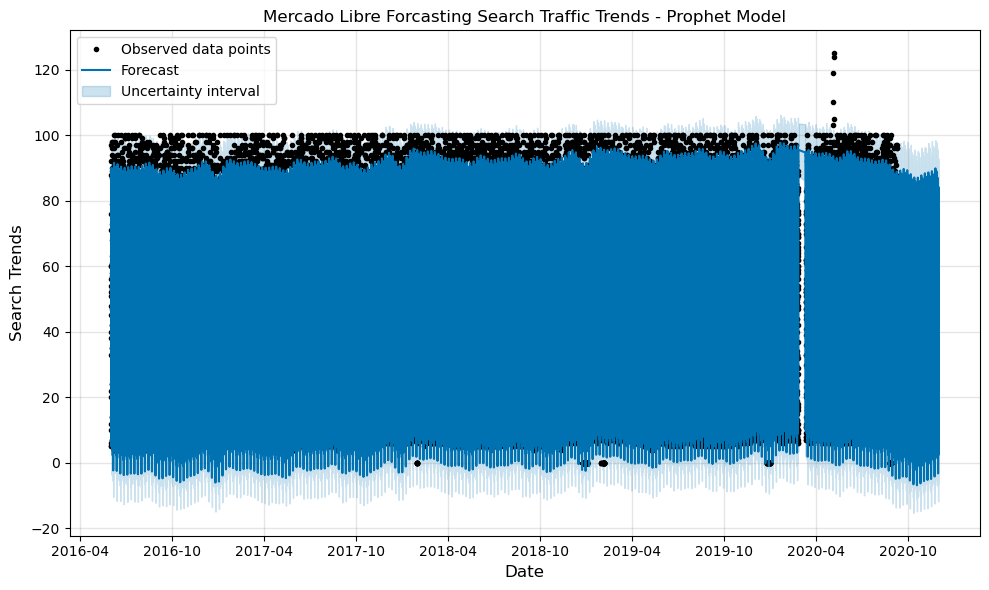

In [30]:
# Plot the Prophet predictions for the Mercado trends data
fig1 = model_mercado_trends.plot(forecast_mercado_trends)
plt.title('Mercado Libre Forcasting Search Traffic Trends - Prophet Model')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Search Trends', fontsize=12)
plt.tight_layout()
plt.legend(loc='upper left')
plt.show()

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:**  The  near-term forecast for the popularity of MercadoLibre is positive with relatively stable overall cyclictical patterns of increased searches followed by slight growth.  

#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [31]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends.set_index('ds')    

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
display(forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']].head())

,yhat,yhat_lower,yhat_upper
0,89.659992,81.391938,97.901098
1,86.106654,77.873208,95.039450
2,75.784037,67.365693,84.880998
3,60.517701,51.840577,69.416239
4,43.403713,35.286604,51.717163


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

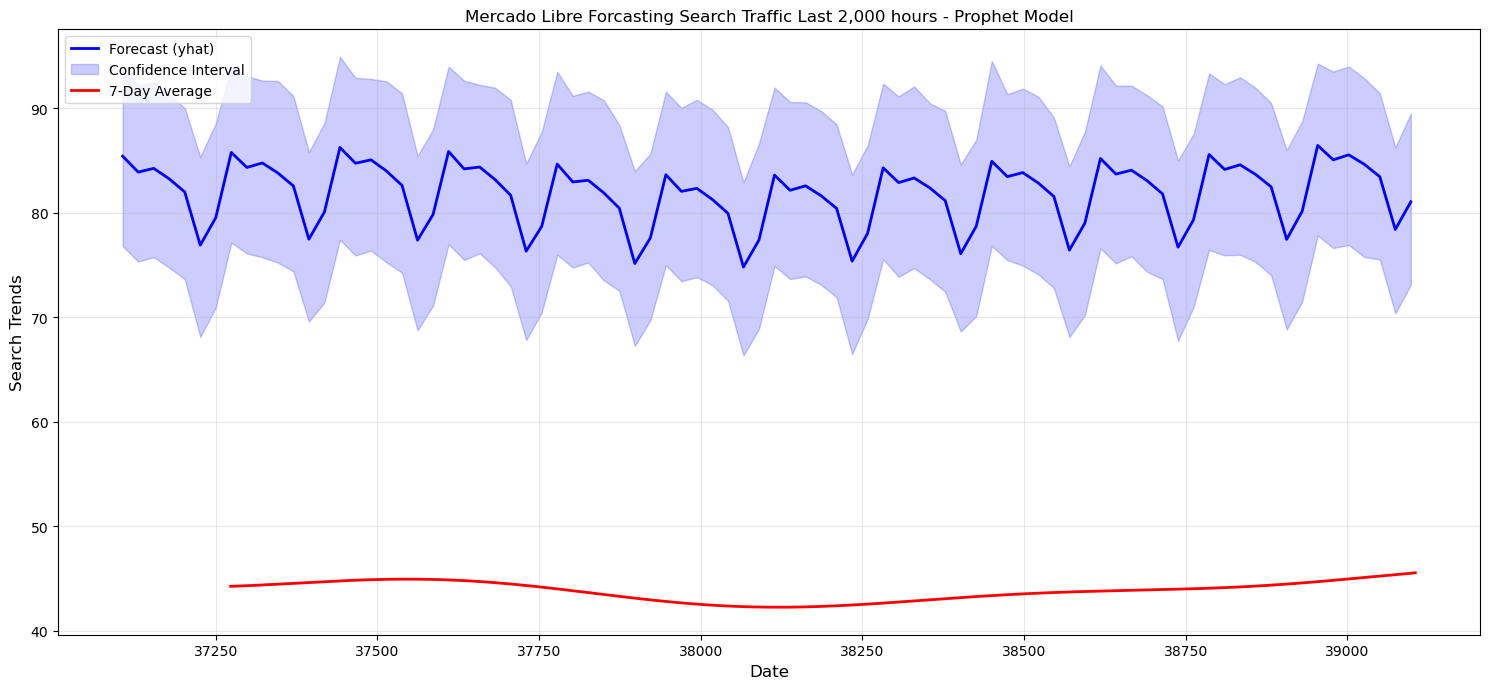

In [32]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
# in 24 hour segments below:
plt.figure(figsize=(15, 7))
sample_indicies = range(0, 2000, 24)
sampled_dates = forecast_mercado_trends.index[-2000:][sample_indicies]
sampled_yhat = forecast_mercado_trends['yhat'][-2000:].iloc[sample_indicies]
sampled_lower = forecast_mercado_trends['yhat_lower'][-2000:].iloc[sample_indicies]
sampled_upper = forecast_mercado_trends['yhat_upper'][-2000:].iloc[sample_indicies]

plt.plot(sampled_dates, sampled_yhat, 'b-', linewidth=2, label='Forecast (yhat)')
plt.fill_between(sampled_dates, sampled_lower, sampled_upper,
                 color='blue', alpha=0.2, label='Confidence Interval')

# Add value  with a 7-day Average trend line
plt.plot(forecast_mercado_trends.index[-2000:],
         forecast_mercado_trends['yhat'][-2000:].rolling(24*7).mean(),
         'r-', linewidth=2, label='7-Day Average')

plt.title('Mercado Libre Forcasting Search Traffic Last 2,000 hours - Prophet Model')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Search Trends', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [33]:
# ORIGINAL PLOT - Too Visually Cluttered
# plt.plot(forecast_mercado_trends.index[-2000:], forecast_mercado_trends['yhat'][-2000:], 
#          label='Forecast (yhat)', color='blue')
# plt.plot(forecast_mercado_trends.index[-2000:], forecast_mercado_trends['yhat_lower'][-2000:], 
#          label='Worst Case (yhat_lower)', linestyle='--', color='red', alpha=0.6)
# plt.plot(forecast_mercado_trends.index[-2000:], forecast_mercado_trends['yhat_upper'][-2000:], 
#          label='Best Case (yhat_upper)', linestyle='--', color='green', alpha=0.6)

# # Second Attampt to view -- as suspected, still not good visually althoiugh Broken out into Seperate Plots
# fig, axes = plt.subplots(3,1, figsize=(15, 11),sharex=True)

# # 1st Plot
# axes[0].plot(forecast_mercado_trends.index[-2000:], forecast_mercado_trends['yhat'][-2000:], 
#              'r-', linewidth= 1.5, label='Forecast (yhat)', color='blue')
# axes[0].set_title('Forecast Mercado Search Trends')
# axes[0].set_ylabel('Search Trends')
# axes[0].legend()

# # 2nd Plot
# axes[1].plot(forecast_mercado_trends.index[-2000:], forecast_mercado_trends['yhat_lower'][-2000:],
#              linewidth= 1.5, label='Worst Case', color='red')
# axes[1].set_title('Worst Case Search Trends (Lower Boundry)')
# axes[1].set_ylabel('Search Trends')
# axes[1].legend()

# # 3rd Plot - Best Case
# axes[2].plot(forecast_mercado_trends.index[-2000:], forecast_mercado_trends['yhat'][-2000:], 
#              linewidth= 1.5, label='Forecast (yhat)', color='green')
# axes[2].set_title('Best Case Forecast Trending (Upper Boundry)')
# axes[2].set_ylabel('Search Trends')
# axes[2].legend()

# plt.tight_layout()
# plt.show()

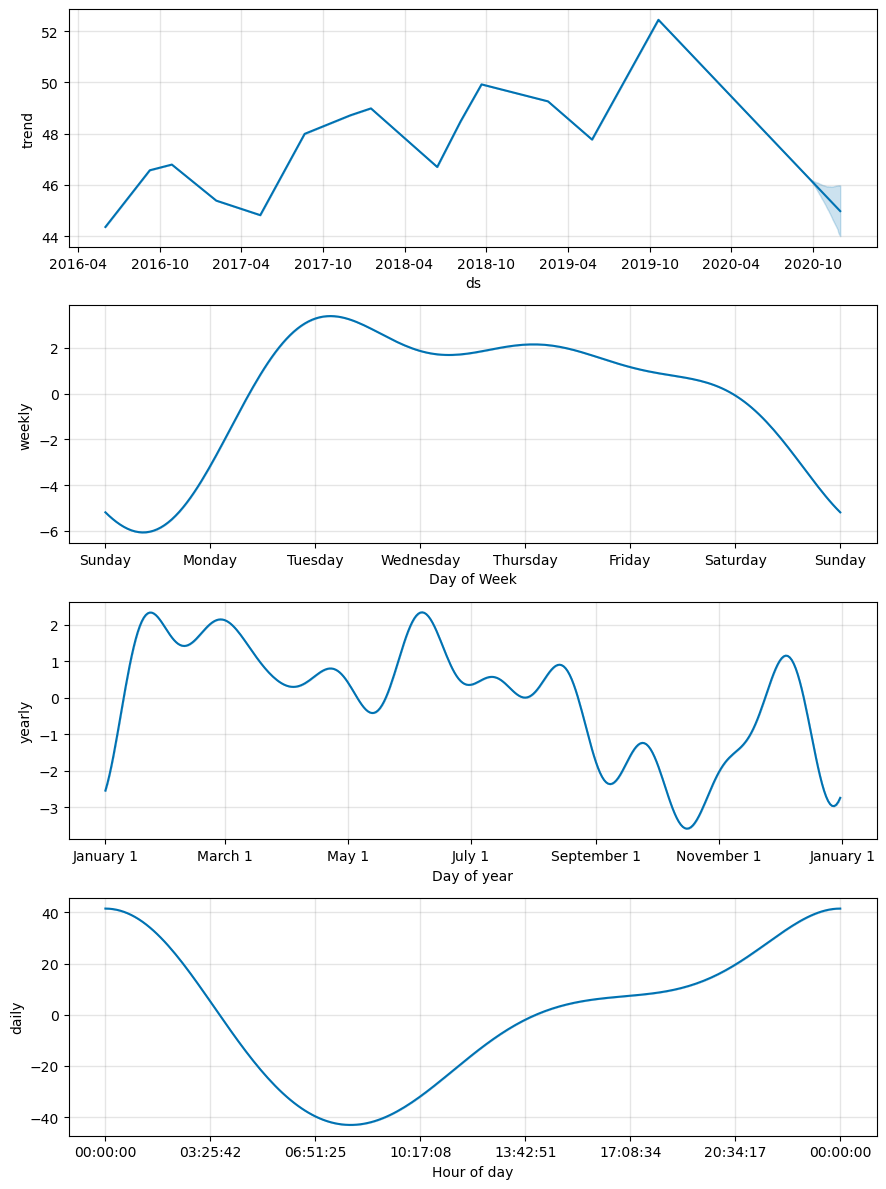

In [34]:
# Reset the index in the forecast_mercado_trends DataFrame
# forecast_mercado_trends = forecast_mercado_trends.set_index('ds')
if isinstance(forecast_mercado_trends.index, pd.DatetimeIndex):
    forecast_mercado_trends = forecast_mercado_trends.reset_index()

# Use the plot_components function to visualize the forecast results
# for the forecast_mercado_trends DataFrame
fig = model_mercado_trends.plot_components(forecast_mercado_trends)
plt.show()

##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:**  Interestingly enough, the late night and early moring hours, between 11pm and 1am see the most search traffic according to Google.

**Question:** Which day of week gets the most search traffic?
   
**Answer:** Mondays get the most traffic, but the trend starts late Sunday Evening, and then Tuesady is the next highest.  Subsequent days continue the downward trend.

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:**  The lowest Search trafic rate occured on December 24, 2018, and is a consistent trend with the span of Christmas through New Year's showing the most significant drop in search activity.
### Lowest Search Traffic Days by year: 
<small>
<div>2016: Day 297 (October 23) - Search Value: 31.08</div>
<div>2017: Day 1 (January 01) - Search Value: 24.58</div>
<div>2018: Day 358 (December 24) - Search Value: 14.46</div>
<div>2019: Day 1 (January 01) - Search Value: 17.17</div>
</small>
### Answer continued:  See the Cell and Plot Below for further Investigation:

In [36]:
# Identifying the lowest point for search traffic in the calendar year

traffic_by_day = mercado_trends_df.copy()
traffic_by_day['year'] = traffic_by_day.index.year
traffic_by_day['day_of_year'] = traffic_by_day.index.dayofyear

traffic_daily_average = traffic_by_day.groupby(['year', 'day_of_year'])['Search Trends'].mean().reset_index()

min_days_by_year = traffic_daily_average.loc[traffic_daily_average.groupby('year')['Search Trends'].idxmin()]

# Convert day of year to actual dates for better interpretation
min_days_by_year['date'] = min_days_by_year.apply(
    lambda row: datetime(int(row['year']), 1, 1) + timedelta(days=int(row['day_of_year'])-1), 
    axis=1
)

print(f"Lowest Search Traffic Days by year: ")
for _, row in min_days_by_year.iterrows():
    print(f"{int(row['year'])}: Day {int(row['day_of_year'])} ({row['date'].strftime('%B %d')}) - Search Value: {row['Search Trends']:.2f}"

SyntaxError: incomplete input (1535072817.py, line 19)